In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [61]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Precipitation Analysis

In [ ]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.id.desc()).first()
print(f"The most recent date in the data set is {recent_date[0]}.")

In [9]:
max_date = session.query(func.max(measurement.date))
for dates in max_date:
    recent_date = dt.datetime.strptime(dates[0], '%Y-%m-%d')
    print(recent_date)

2017-08-23 00:00:00


In [62]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [116]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
                    filter(measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame and set the index to the date column\
one_year_df = pd.DataFrame(results, columns= ['date', 'precipitation'])

one_year_df

,date,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


In [117]:

one_year_df.set_index('date', inplace = True)
one_year_df = one_year_df.dropna()

# Sort the dataframe by date
one_year_df = one_year_df.sort_values('date')

one_year_df

,precipitation
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


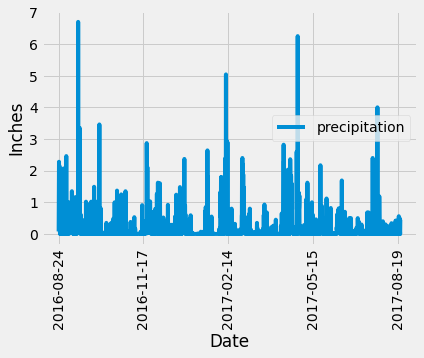

In [119]:

# Use Pandas Plotting with Matplotlib to plot the data
one_year_df.plot(rot = 90)
#plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()



In [120]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_df['precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station).count()
print(f"There are {total_stations} stations")

There are 9 stations


In [36]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activity =session.query(measurement.station, func.count(measurement.prcp)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.prcp).desc()).all()

activity

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                    filter(measurement.station == 'USC00519281')

most_active_df = pd.DataFrame(most_active, columns=['station', 'min', 'max', 'average'])
most_active_df


,station,min,max,average
0,USC00519281,54.0,85.0,71.663781


Text(0.5, 0, 'Temperature')

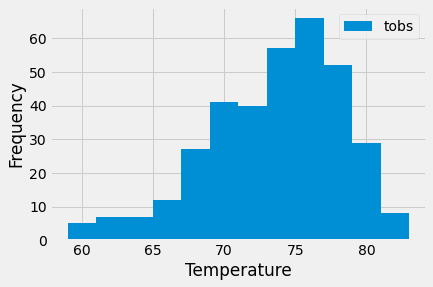

In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_12 = session.query(measurement.tobs).\
                    filter(measurement.station == 'USC00519281').\
                    filter(measurement.date >= one_year_ago)

most_active_12_df = pd.DataFrame(most_active_12, columns=['tobs'])
most_active_12_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.show()

# Close session

In [ ]:
# Close Session
session.close()